In [1]:
import sys
sys.path.append('..')
from mtDNAsim import *
import pandas as pd
import numpy as np
from copy import deepcopy
from collections import Counter
import argparse
import phylovelo as pv
import pickle

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [12]:
# parser = argparse.ArgumentParser(description='save file name')
# parser.add_argument('-p', type=str)
# parser.add_argument('-f', type=str)
# parser.add_argument('-m', type=str)
# parser.add_argument('-bn', type=str)
filename = '1234'
data_path = '/home/wangkun/mtDNA_simulation/scripts/test/'
model = 'bifurcated'
bn = 'mid'

In [15]:
os.mkdir(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/")

# if data_path is None:
#     data_path = "../results"

In [16]:
num_elements = 5

while True:
    num_elements = 5
    system = Gillespie(
        num_elements,
        inits=[1, 0, 0, 0, 0],
        max_cell_num=20000
    )

    p0 = lambda t: (1 - 1 / (1 + np.exp(-0.5 * (t - 19))))
    p1 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 18))))
    p2 = lambda t: 1
    d00 = lambda t: 0.4* (1 / (1 + np.exp(-0.5 * (t - 16))))
    d01 = lambda t: 0.4* (1 / (1 + np.exp(-0.5 * (t - 16))))
    d10 = lambda t: 0.4* (1 / (1 + np.exp(-0.6 * (t - 16))))
    d11 = lambda t: 0.4* (1 / (1 + np.exp(-0.6 * (t - 16))))


    system.add_reaction(p0, [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], index=0)
    system.add_reaction(p1, [0, 1, 0, 0, 0], [0, 2, 0, 0, 0], index=1)
    system.add_reaction(p1, [0, 0, 1, 0, 0], [0, 0, 2, 0, 0], index=2)
    system.add_reaction(p2, [0, 0, 0, 1, 0], [0, 0, 0, 2, 0], index=3)
    system.add_reaction(p2, [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], index=4)
    system.add_reaction(d00, [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], index=5)
    system.add_reaction(d01, [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], index=6)
    system.add_reaction(d10, [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], index=7)
    system.add_reaction(d11, [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], index=8)

    system.evolute(20000000)
    
    tree_file_name = f"tree_origin_bif_{filename}.csv"
    cell_num_file_name = f"cell_num_bif_{filename}.csv"

    curr_cells = []
    t = np.array(system.generation_time)
    cell_num_traj = np.array(system.n)

    for i in system.curr_cells.values():
        curr_cells += i
    # while tree_file_name in os.listdir(data_path):
    #     tree_file_name = tree_file_name[:-1] + str(int(tree_file_name[-1]) + 1)


    #     cell_num_file_name = cell_num_file_name[:-1] + str(int(cell_num_file_name[-1]) + 1)

    np.savetxt(
        f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/{cell_num_file_name}",
        np.hstack((t.reshape(-1, 1), cell_num_traj)),
        fmt="%.5f",
    )

    sim_utils.wirte_lineage_info(
        f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/{tree_file_name}", system.anc_cells, curr_cells, system.t[-1]
    )
    try:
        reconstruct(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/tree_origin_bif_{filename}.csv", output=f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/bif_tree_gt_{filename}.nwk", num=5000, is_balance=True)
        break
    except:
        os.system(f"rm {data_path}/{model}_{bn.replace('mid', '')}/{filename}/{tree_file_name}")
        os.system(f"rm {data_path}/{model}_{bn.replace('mid', '')}/{filename}/{cell_num_file_name}")

  0%|          | 0/20000 [00:00<?, ?it/s]

In [18]:
tree_file = f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/bif_tree_gt_{filename}.nwk"
phylo_tree, branch_colors = loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
cell_names, cell_states, cell_generation = get_annotation(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/tree_origin_bif_{filename}.csv")
cell_states = pd.DataFrame(data=cell_states, index=cell_names).loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names).loc[sampled_cells].to_numpy()

sd = scData(
    phylo_tree=phylo_tree,
    cell_states=cell_states.to_numpy().T[0].astype('int'),
    cell_generation=cell_generation.T[0].astype('int'),
    cell_names=sampled_cells
)

ge, base_expr = sim_base_expr(sd.phylo_tree,
                                 cell_states,
                                 Ngene=4000,
                                 r_variant_gene=0.4,
                                 diff_map={0:[0],1:[0],2:[0],3:[1],4:[1]},
                                 pseudo_state_time={0:[0,5], 1:[7,12], 2:[7,12], 3:[13,18], 4:[13,18]},
                                 forward_map={},
                                 mu0_loc=0,
                                 mu0_scale=1,
                                 drift_loc=0,
                                 drift_scale=0.05,
                                )

sd.count = get_count_from_base_expr(add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.5)
sd.count.to_csv(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/count_bif_{filename}.csv")
sd.dimensionality_reduction(method='tsne', scale=100, perplexity=150, target='count')
sd.Xdr.to_csv(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/umap_bif_{filename}.csv")

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [22]:
cell_states = cell_states.to_numpy().flatten()

In [28]:
sd.dimensionality_reduction(method='tsne', scale=50, perplexity=100, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


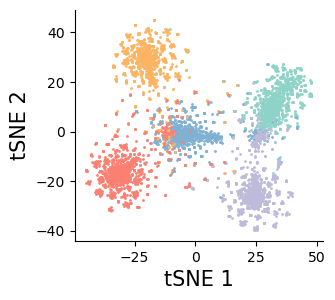

In [29]:
fig, ax = plt.subplots(figsize=(3.2,3))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[cell_states==i, 0], sd.Xdr.iloc[cell_states==i, 1], c=cmps[i],s=1)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [66]:




# seqs = DNAmutation(phylo_tree, mut_rate=0.5)
# seqs = seqs.astype(int)

mt_cn = {
    'early':lambda x: 1.3 if x <= 5 else 2.2,
    'mid':lambda x: 1.6 if x <= 10 else 2.25,
    'late':lambda x: 1.8 if x <= 20 else 2.4,
    'const':lambda x: 2 
}

#for bn in ['const', 'mid']:
for imr in [0.1]:
    success = 0
    while not success:
        try:
            mt_muts, mutid = mtmutation(phylo_tree, mut_rate=0.0008, init_mut_rate=imr, mt_copynumber=mt_cn[bn], nmts=500)
            success = 1
        except:
            None

    pre_existing_mut = set()
    for i in mt_muts['<0_0>']:
        pre_existing_mut = pre_existing_mut.union(i)
    pickle.dump(mt_muts, open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt_allmuts_{bn}_{imr}_{filename}.pkl", 'wb'))
    mf = mut_freq(mt_muts, mutid, sel_cells=[i.name for i in phylo_tree.get_terminals()])
    mt_seqs = mf.astype(bool).astype(int)
    mt_pre = mt_seqs[mt_seqs.columns[np.isin(mt_seqs.columns, list(pre_existing_mut))]]
    mt_dn =  mt_seqs[mt_seqs.columns[~np.isin(mt_seqs.columns, list(pre_existing_mut))]]
    mf.to_csv(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt_mut_freq_{bn}_{imr}_{filename}.csv")
    mf1 = deepcopy(mf)
    mf1[mf1<0.01] = 0
    mt1_seqs = mf1.astype(bool).astype(int)
    mt1_pre = mt1_seqs[mt1_seqs.columns[np.isin(mt1_seqs.columns, list(pre_existing_mut))]]
    mt1_dn =  mt1_seqs[mt1_seqs.columns[~np.isin(mt1_seqs.columns, list(pre_existing_mut))]]

    mf5 = deepcopy(mf)
    mf5[mf5<0.05] = 0
    mt5_seqs = mf5.astype(bool).astype(int)
    mt5_pre = mt5_seqs[mt5_seqs.columns[np.isin(mt5_seqs.columns, list(pre_existing_mut))]]
    mt5_dn =  mt5_seqs[mt5_seqs.columns[~np.isin(mt5_seqs.columns, list(pre_existing_mut))]]

#     with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt_mut_{bn}_{imr}_{filename}.phy", 'w') as f:
#         f.write('{} {}\n'.format(*mt_seqs.shape))
#         for cell in mt_seqs.index:
#             f.write('{} {}\n'.format(cell[1:-1], ''.join(mt_seqs.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

#     with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt_mut_{bn}_{imr}_pre_{filename}.phy", 'w') as f:
#         f.write('{} {}\n'.format(*mt_pre.shape))
#         for cell in mt_pre.index:
#             f.write('{} {}\n'.format(cell[1:-1], ''.join(mt_pre.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

#     with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt_mut_{bn}_{imr}_dn_{filename}.phy", 'w') as f:
#         f.write('{} {}\n'.format(*mt_dn.shape))
#         for cell in mt_dn.index:
#             f.write('{} {}\n'.format(cell[1:-1], ''.join(mt_dn.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))  

#     with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt1_mut_{bn}_{imr}_{filename}.phy", 'w') as f:
#         f.write('{} {}\n'.format(*mt1_seqs.shape))
#         for cell in mt1_seqs.index:
#             f.write('{} {}\n'.format(cell[1:-1], ''.join(mt1_seqs.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

#     with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt1_mut_{bn}_{imr}_pre_{filename}.phy", 'w') as f:
#         f.write('{} {}\n'.format(*mt1_pre.shape))
#         for cell in mt1_pre.index:
#             f.write('{} {}\n'.format(cell[1:-1], ''.join(mt1_pre.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

#     with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt1_mut_{bn}_{imr}_dn_{filename}.phy", 'w') as f:
#         f.write('{} {}\n'.format(*mt1_dn.shape))
#         for cell in mt1_dn.index:
#             f.write('{} {}\n'.format(cell[1:-1], ''.join(mt1_dn.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))    

#     with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt5_mut_{bn}_{imr}_{filename}.phy", 'w') as f:
#         f.write('{} {}\n'.format(*mt5_seqs.shape))
#         for cell in mt5_seqs.index:
#             f.write('{} {}\n'.format(cell[1:-1], ''.join(mt5_seqs.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

#     with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt5_mut_{bn}_{imr}_pre_{filename}.phy", 'w') as f:
#         f.write('{} {}\n'.format(*mt_pre.shape))
#         for cell in mt5_pre.index:
#             f.write('{} {}\n'.format(cell[1:-1], ''.join(mt5_pre.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

#     with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/mt5_mut_{bn}_{imr}_dn_{filename}.phy", 'w') as f:
#         f.write('{} {}\n'.format(*mt_dn.shape))
#         for cell in mt5_dn.index:
#             f.write('{} {}\n'.format(cell[1:-1], ''.join(mt5_dn.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))     

# with open(f"{data_path}/{model}_{bn.replace('mid', '')}/{filename}/dna_mut_{filename}.phy", 'w') as f:
#     f.write('{} {}\n'.format(*seqs.shape))
#     for cell in seqs.index:
#         f.write('{} {}\n'.format(cell[1:-1], ''.join(seqs.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/21191 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [67]:
from collections import defaultdict

In [68]:
mt_cnt = defaultdict(list)
for i in mt_muts:
    mt_cnt[i.split('_')[0][1:]].append(len(mt_muts[i]))

In [69]:
mt_cnt.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34'])

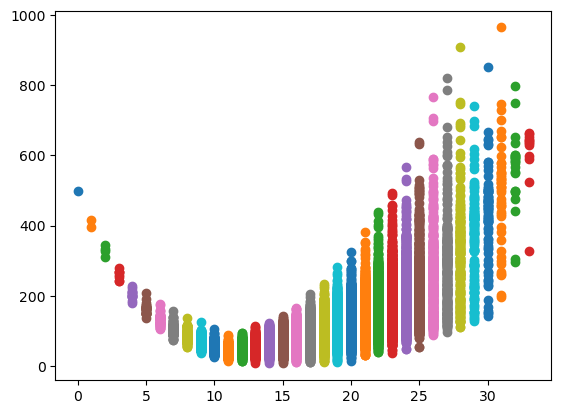

In [70]:
for i in range(34):
    plt.scatter([i]*len(mt_cnt[str(i)]), mt_cnt[str(i)])